In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, exposure, transform, io
from sklearn.cross_validation import train_test_split
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
K.set_image_data_format('channels_first')


# Define the number of outputs to train and image size
NUM_CLASSES = 43 # 43 for GTSRB and 164 for European dataset
IMG_SIZE = 48

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
import keras
import tensorflow as tf
import sys

print('Keras version', keras.__version__)
print('Tensorflow version', tf.__version__)
print('Python version', sys.version)

Keras version 2.2.0
Tensorflow version 1.8.0
Python version 3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


## Function definitions for reading the data

In [3]:
def preprocess_img(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img, -1)

    return img


def get_class(img_path):
    return int(img_path.split('/')[-2])

## Read the data

In [4]:
# Read the training data

# Define the path to your traning dataset (GTSRB - Training)
root_dir = '../../Datasets/Traffic_signs/German_Recognition/Final_Training/Images'
imgs = []
labels = []

# Read all image paths with extension ppm
all_img_paths = sorted(glob.glob(os.path.join(root_dir, '*/*.ppm')))
np.random.seed(42)
np.random.shuffle(all_img_paths)

# Read images and pre-process them
for img_path in all_img_paths:
    img = preprocess_img(io.imread(img_path))
    label = get_class(img_path)
    
    imgs.append(img)
    labels.append(label)

X = np.array(imgs, dtype='float32')
# Binarize the labels
Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [5]:
# Read the testing data

# Define the path to your testing dataset (GTSRB - Test)
root_dir = '../../Datasets/Traffic_signs/German_Recognition/Final_Test/Images' # images are in folders like in training set
X_test = []
y_test = []
paths_test=[]

# Read all image paths with extension ppm
all_img_paths = sorted(glob.glob(os.path.join(root_dir, '*/*.ppm')))
np.random.seed(42)
np.random.shuffle(all_img_paths)

# Read images and pre-process them
for img_path in all_img_paths:
    img = preprocess_img(io.imread(img_path))
    paths_test.append(img_path)
    
    label = get_class(img_path)
    X_test.append(img)
    y_test.append(label)

X_test = np.array(X_test, dtype='float32')
# Binarize the labels
y_test = np.eye(NUM_CLASSES, dtype='uint8')[y_test]


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [6]:
# Split training data into train and validation sets
# random_state helps defining the same split always with a seed of 42. Otherwise the split will always be different
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

In [7]:
# Normalize the data
normalize = 0

# Subtract the mean image
if normalize:
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

In [8]:
print ('Training data shape: ', X.shape)
print ('Training labels shape:', Y.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', Y_val.shape)
print ('Testing data sahep: ', X_test.shape)
print ('Testing labels shape: ', y_test.shape)

Training data shape:  (39209, 3, 48, 48)
Training labels shape: (39209, 43)
Validation data shape:  (3921, 3, 48, 48)
Validation labels shape:  (3921, 43)
Testing data sahep:  (12630, 3, 48, 48)
Testing labels shape:  (12630, 43)


## Model definition

In [4]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

## Initialize the model and training parameters

In [5]:
model = cnn_model()

batch_size = 128
epochs = 40

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# weights initialization
def my_init(shape, name=None):
    value = np.random.random(shape)
    return K.variable(value, name=name)

## Start the training

In [11]:
# Save the training history
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val,Y_val),
          callbacks=[LearningRateScheduler(lr_schedule),
                     ModelCheckpoint('german_cnn.h5', save_best_only=True)]
          )

Train on 35288 samples, validate on 3921 samples
Epoch 1/40
35288/35288 [==============================] - 6s 163us/step - loss: 2.7095 - acc: 0.2619 - val_loss: 0.7656 - val_acc: 0.7733
Epoch 2/40
35288/35288 [==============================] - 5s 134us/step - loss: 0.5741 - acc: 0.8183 - val_loss: 0.1431 - val_acc: 0.9564
Epoch 3/40
35288/35288 [==============================] - 5s 131us/step - loss: 0.2391 - acc: 0.9240 - val_loss: 0.0667 - val_acc: 0.9796
Epoch 4/40
35288/35288 [==============================] - 5s 131us/step - loss: 0.1553 - acc: 0.9512 - val_loss: 0.0468 - val_acc: 0.9875
Epoch 5/40
35288/35288 [==============================] - 5s 129us/step - loss: 0.1097 - acc: 0.9663 - val_loss: 0.0340 - val_acc: 0.9885
Epoch 6/40
35288/35288 [==============================] - 5s 129us/step - loss: 0.0861 - acc: 0.9732 - val_loss: 0.0276 - val_acc: 0.9913
Epoch 7/40
35288/35288 [==============================] - 5s 130us/step - loss: 0.0734 - acc: 0.9761 - val_loss: 0.0267 - v

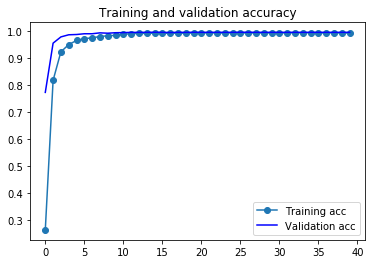

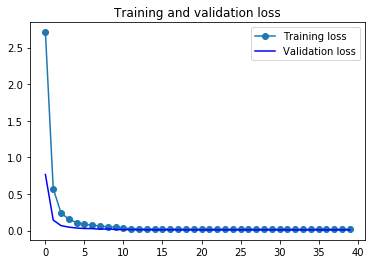

In [12]:
# Plot the learning curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '-o', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc=4)

plt.figure()

plt.plot(epochs, loss, '-o', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model evlauation

In [13]:
# evaluate loaded model on test data
score = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("[INFO] %s: %.2f%%" % (model.metrics_names[1], score[1]*100))

12630/12630 [==============================] - 1s 64us/step
[INFO] acc: 96.84%


In [14]:
# load weights into new model (best weights)
model2 = cnn_model() 
model2.load_weights('GTSRB_weights/cnn_german.h5')
print("Loaded weights from disk")
 
# evaluate loaded model on test data
model2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
score = model2.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("[INFO] %s: %.2f%%" % (model2.metrics_names[1], score[1]*100))

Loaded weights from disk
12630/12630 [==============================] - 1s 61us/step
[INFO] acc: 97.32%


# Data augmentation

In [19]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.cross_validation import train_test_split
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

datagen.fit(X_train)

# Reinitialize model and compile
#model = cnn_model()
#model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train again
epochs = 40

history2=model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0]/batch_size,
                    epochs=epochs,
                    validation_data=(X_val, Y_val),
                    callbacks=[LearningRateScheduler(lr_schedule),
                               ModelCheckpoint('cnn_german_aug.h5', save_best_only=True)]
                    )

Epoch 1/40
276/275 [==============================] - 14s 52ms/step - loss: 0.0630 - acc: 0.9805 - val_loss: 0.0053 - val_acc: 0.9985
Epoch 2/40
276/275 [==============================] - 14s 51ms/step - loss: 0.0578 - acc: 0.9816 - val_loss: 0.0068 - val_acc: 0.9982
Epoch 3/40
276/275 [==============================] - 14s 50ms/step - loss: 0.0566 - acc: 0.9829 - val_loss: 0.0083 - val_acc: 0.9964
Epoch 4/40
276/275 [==============================] - 14s 51ms/step - loss: 0.0529 - acc: 0.9837 - val_loss: 0.0037 - val_acc: 0.9987
Epoch 5/40
276/275 [==============================] - 14s 50ms/step - loss: 0.0512 - acc: 0.9838 - val_loss: 0.0051 - val_acc: 0.9987
Epoch 6/40
276/275 [==============================] - 14s 50ms/step - loss: 0.0486 - acc: 0.9849 - val_loss: 0.0034 - val_acc: 0.9980
Epoch 7/40
276/275 [==============================] - 14s 51ms/step - loss: 0.0446 - acc: 0.9854 - val_loss: 0.0052 - val_acc: 0.9985
Epoch 8/40
276/275 [==============================] - 14s 51ms

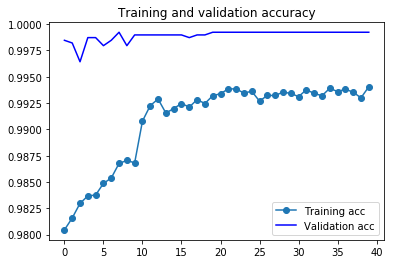

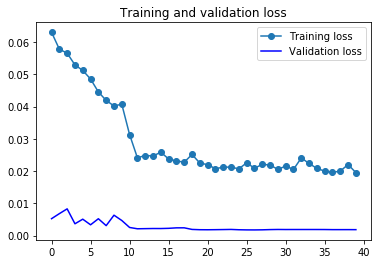

In [20]:
# Plot the learning curves
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '-o', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc=4)

plt.figure()

plt.plot(epochs, loss, '-o', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
# evaluate loaded model on test data
score = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

12630/12630 [==============================] - 1s 53us/step
acc: 98.52%


In [15]:
# load weights into new model (best weights)
model2 = cnn_model() 
model2.load_weights('GTSRB_weights/cnn_german_aug.h5')
#model2.load_weights('model_aug3_98.94.h5')
print("Loaded model from disk")
 
# evaluate loaded model on test data
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
score = model2.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("%s: %.2f%%" % (model2.metrics_names[1], score[1]*100))

Loaded model from disk
12630/12630 [==============================] - 1s 65us/step
acc: 98.99%


In [6]:
# Print model information
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 48, 48)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 46, 46)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 23, 23)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 23, 23)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 23, 23)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 21, 21)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 10, 10)        0         
__________